In [9]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

# from tensorflow.keras import layers
# from tensorflow.keras import models
from IPython import display
import tensorflow as tf
import tensorflow_io as tfio
import pandas as pd
import librosa 

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
audio_path = 'dataset/AUDIO/breathing/'
audio_path_new = 'dataset/AUDIO_NEW/breathing/'

In [3]:
# Label files as COVID/NOT COVID
metadata_path = 'dataset/metadata.csv'
metadata_df = pd.read_csv(metadata_path, sep = ' ', )

In [4]:
metadata_df.head()

SUB_ID COVID_STATUS GENDER
0  NPHYFCYK            n      m
1  HTCFAFDO            n      m
2  XLIOSZXS            n      m
3  FONIOYTJ            n      m
4  DZEREGIM            n      m

In [5]:
# Define paths
covid_positive_folder = os.path.join(audio_path_new, 'COVID_Positive')
covid_negative_folder = os.path.join(audio_path_new, 'COVID_Negative')

# Create subfolders if they don't exist
os.makedirs(covid_positive_folder, exist_ok=True)
os.makedirs(covid_negative_folder, exist_ok=True)

In [6]:
COVID_FILE = os.path.join(covid_positive_folder, 'ZYSOZDNN.flac')

In [14]:
# Load the audio file
y, sr = librosa.load(COVID_FILE, sr=16000)

# Extract Mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

# Convert to log scale (dB)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Expand dimensions to match TensorFlow input shape (batch_size, height, width, channels)
# log_mel_spectrogram = np.expand_dims(log_mel_spectrogram, axis=-1)
# log_mel_spectrogram = np.expand_dims(log_mel_spectrogram, axis=0)

print(log_mel_spectrogram.shape)  # Example shape: (1, 128, time_steps, 1)

(128, 358)


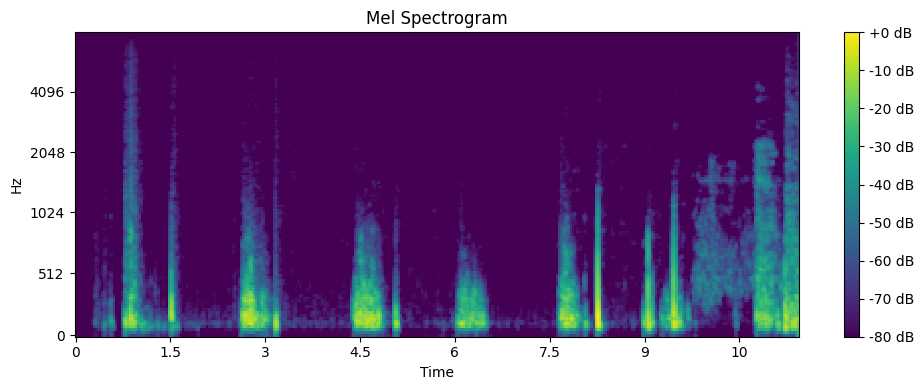

In [15]:
# Plot the Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

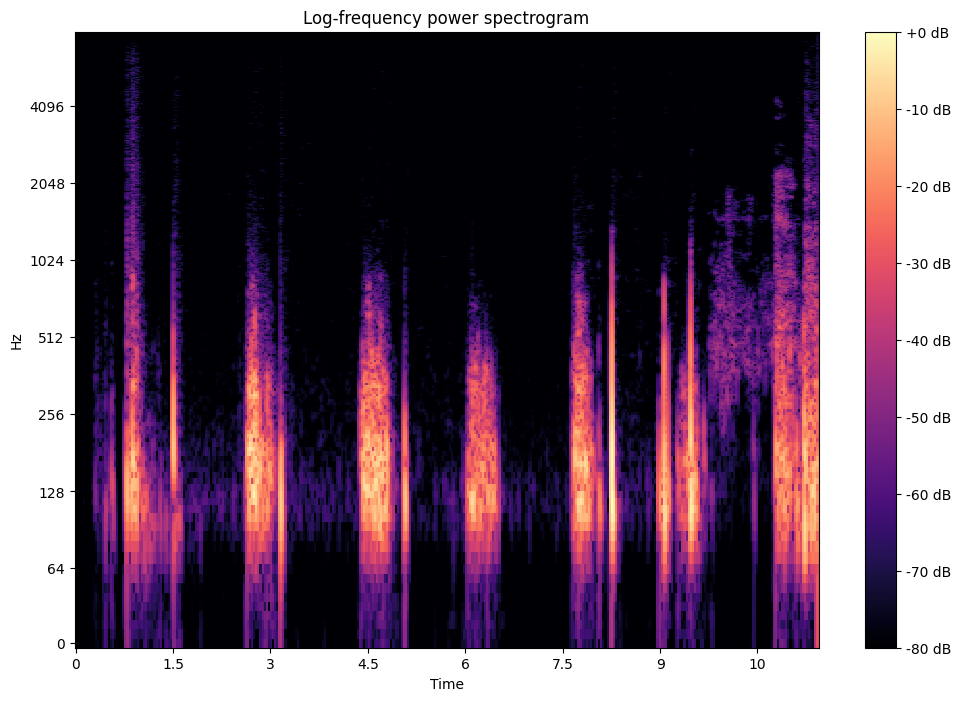

In [11]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(12, 8))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.show()

In [7]:
# wav = tfio.audio.AudioIOTensor(COVID_FILE)

AttributeError: module '77ab628d7ad4acaa62f6bde524b9d631895821c9' has no attribute 'io_audio_readable_init'

In [6]:
#@tf.function(reduce_retracing=True)
def load_wav_16k_mono(filename):
    # lazy loading
    audio = tfio.audio.AudioIOTensor(filename, dtype=tf.int16)
    # Removes trailing axis, convert lazy loaded audio data to regular tensor
    audio_tensor = tf.squeeze(audio.to_tensor(), axis=-1)
    #tf.print("Tensor values:", audio_tensor)
    audio_tensor = tf.cast(audio_tensor, dtype=tf.float32)
    #tf.print("Tensor values:", audio_tensor)
    sample_rate = tf.cast(audio.rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    flac = tfio.audio.resample(audio_tensor, rate_in=sample_rate, rate_out=16000)
    return flac

In [15]:
wave = load_wav_16k_mono(COVID_FILE)

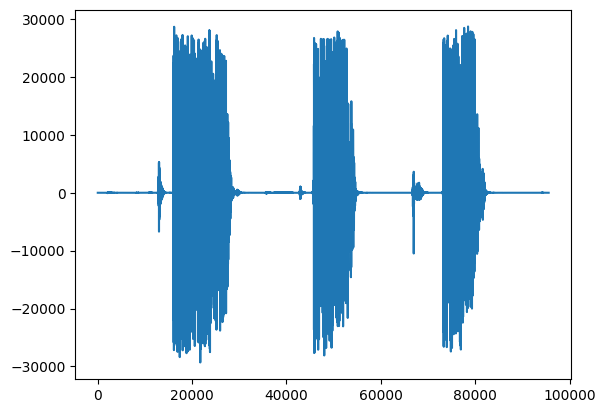

In [32]:
coughing_path_sample = 'dataset/AUDIO/cough/ZZZCJPYV.flac'
coughing_wave = load_wav_16k_mono(coughing_path_sample)
plt.plot(coughing_wave)
plt.show()

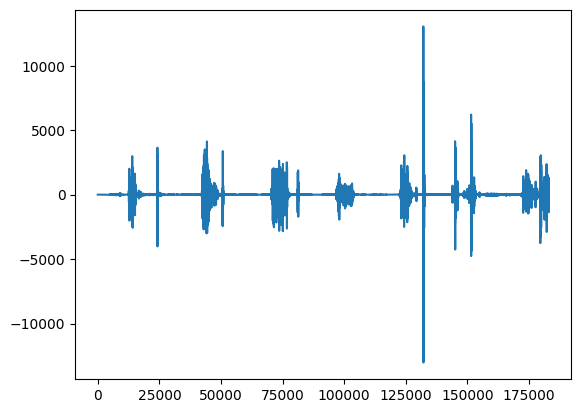

In [16]:
plt.plot(wave)
plt.show()

In [7]:
POS = covid_positive_folder
NEG = covid_negative_folder

In [8]:
pos = tf.data.Dataset.list_files(POS+'/*.flac')
neg = tf.data.Dataset.list_files(NEG+'/*.flac')

In [9]:
#Add labels and Combine Positive and Negative Samples
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [10]:
#https://www.tensorflow.org/io/tutorials/audio

def preprocess(file_path, label):
    audio = load_wav_16k_mono(file_path)
    # frame length
    # long: higher frequency resolution; short: better time resolution

    # frame step:
    # increasing frame length helps capture details
    # small hop: more overlap -> useful if content is not changing rapidly
    spectrogram = tf.signal.stft(audio, frame_length=512, frame_step=128)

    # extracts magnitude/amplitude/loudness
    spectrogram = tf.abs(spectrogram)

    # logarithmic transformation for better viz
    spectrogram = tf.math.log(spectrogram + 1e-6)
    # adds extra dimension to the spectrogram tensor for CNN
    # [time_frames, frequency_bins] -> [time_frames, frequency_bins, 1]
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [26]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [49]:
spectrogram, label = preprocess(filepath, label)

In [50]:
cough_spectrogram, cough_label = preprocess(coughing_path_sample, 1)

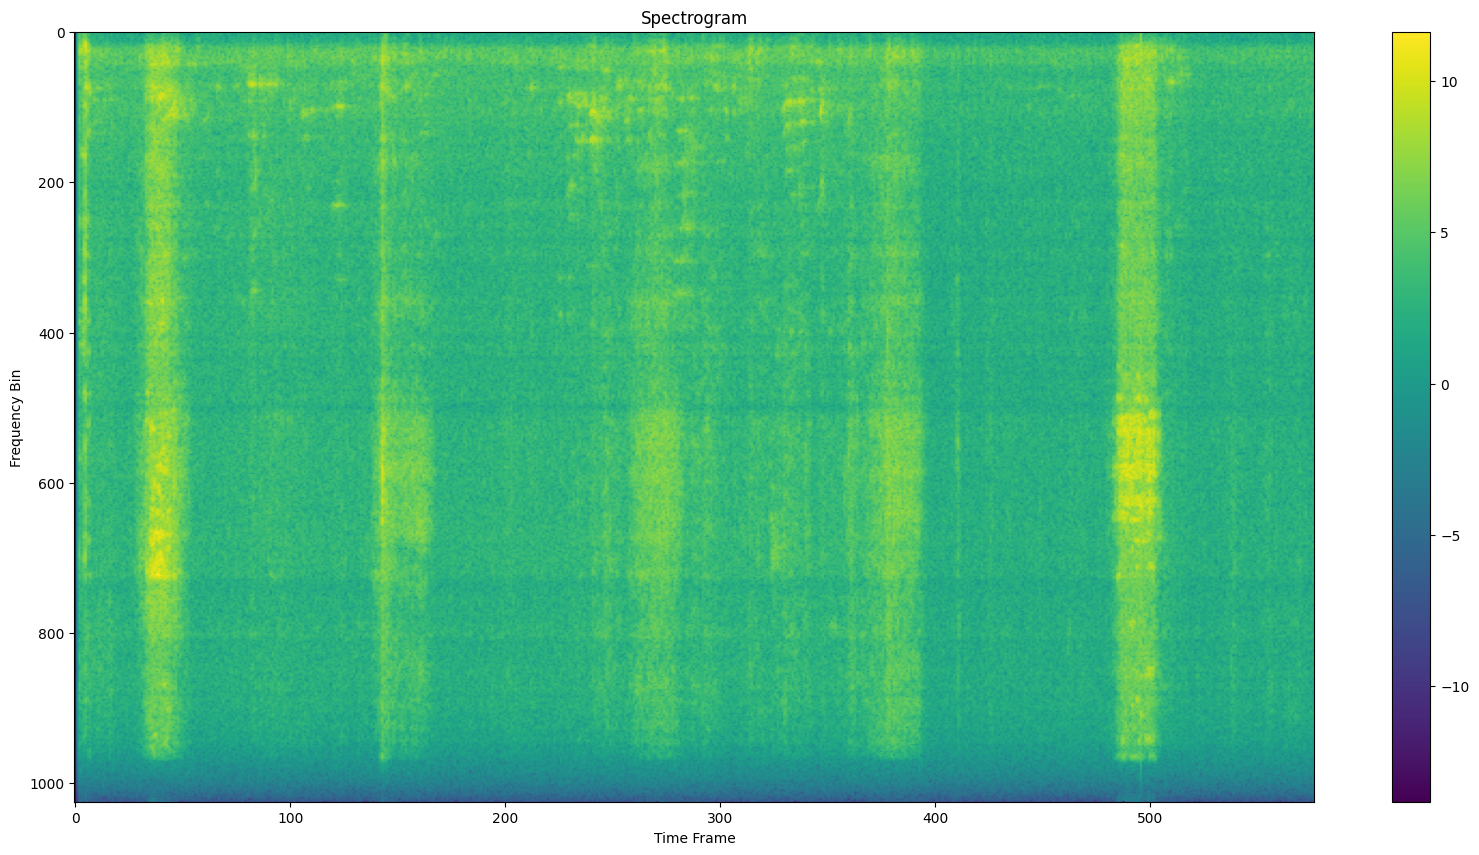

In [51]:
plt.figure(figsize=(20, 10))
plt.imshow(tf.transpose(tf.squeeze(spectrogram)), aspect='auto', cmap='viridis')
plt.colorbar()
plt.xlabel('Time Frame')
plt.ylabel('Frequency Bin')
plt.title('Spectrogram')
plt.show()

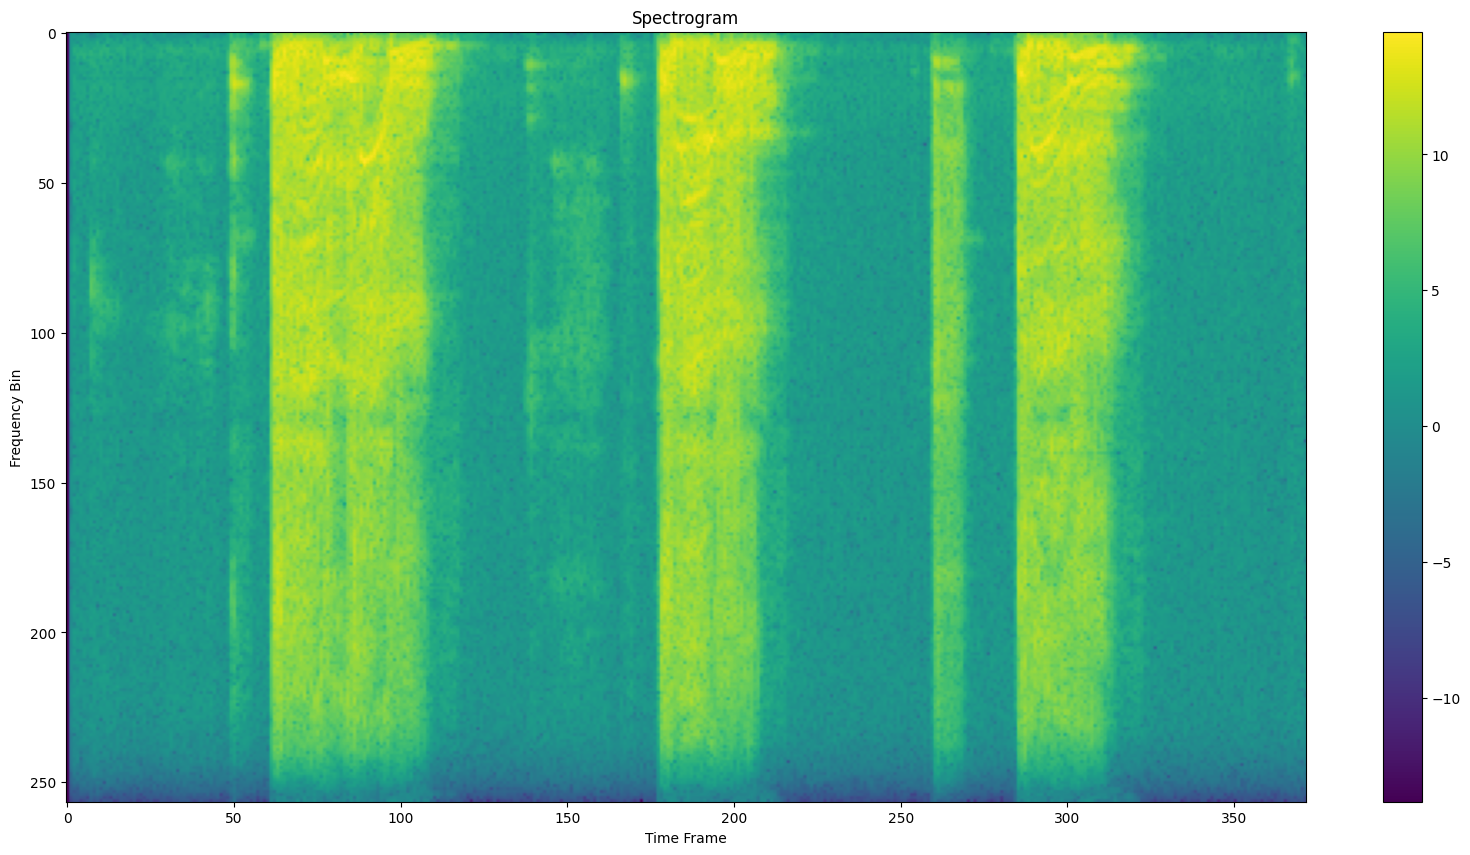

In [46]:
plt.figure(figsize=(20, 10))
plt.imshow(tf.transpose(tf.squeeze(cough_spectrogram)), aspect='auto', cmap='viridis')
plt.colorbar()
plt.xlabel('Time Frame')
plt.ylabel('Frequency Bin')
plt.title('Spectrogram')
plt.show()

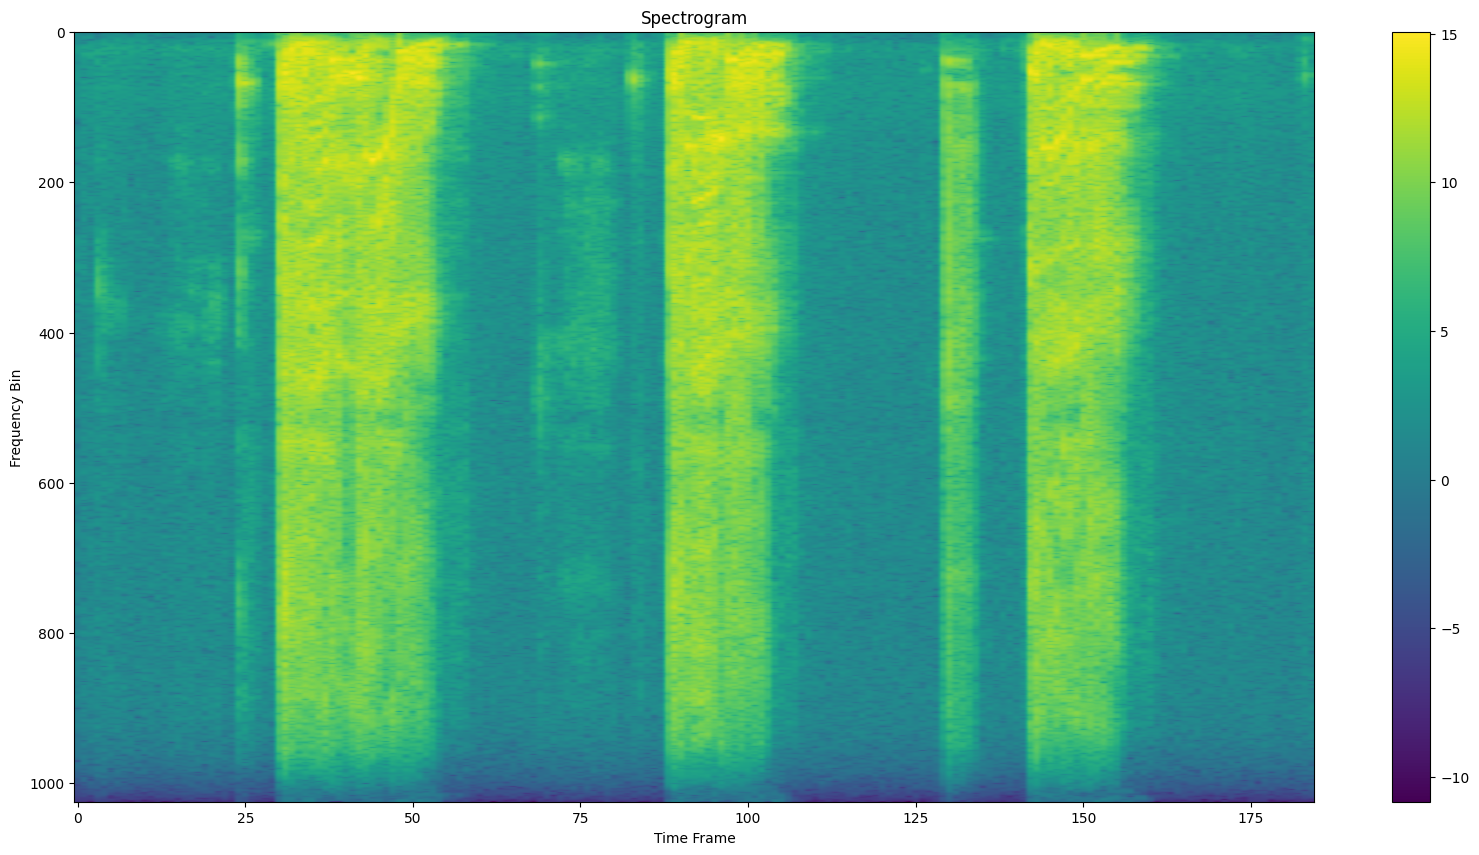

In [52]:
plt.figure(figsize=(20, 10))
plt.imshow(tf.transpose(tf.squeeze(cough_spectrogram)), aspect='auto', cmap='viridis')
plt.colorbar()
plt.xlabel('Time Frame')
plt.ylabel('Frequency Bin')
plt.title('Spectrogram')
plt.show()

In [11]:
# create tensorflow pipeline

data = data.map(preprocess)
data = data.cache()

# Shuffling helps prevent the model from learning any unintended patterns related to the order of the data.
# The buffer_size=1000 means that 1000 elements are kept in a buffer and shuffled before being batched.
# A larger buffer size results in better randomization but requires more memory.
data = data.shuffle(buffer_size=1000)

# By prefetching 8 batches, it allows the next batch of data to be prepared while the current batch is being processed by the model.
# This helps keep the GPU or CPU busy and reduces idle time, improving training efficiency.
data = data.batch(16)
data = data.prefetch(8)

AssertionError: in user code:

    File "/var/folders/y3/1ld116210xs2ztcb6hbqjrhm0000gn/T/ipykernel_21054/1870307507.py", line 4, in preprocess  *
        audio = load_wav_16k_mono(file_path)
    File "/var/folders/y3/1ld116210xs2ztcb6hbqjrhm0000gn/T/ipykernel_21054/2064829229.py", line 4, in load_wav_16k_mono  *
        audio = tfio.audio.AudioIOTensor(filename)
    File "/Users/opheliasin/covid-detection/myenv/lib/python3.9/site-packages/tensorflow_io/python/ops/audio_ops.py", line 670, in __init__  **
        assert dtype is not None, "dtype must be provided in graph mode"

    AssertionError: dtype must be provided in graph mode


In [ ]:
# Split into Training and Testing Partitions

train = data.take(36)
test = data.skip(36).take(15)